**Driver Behavior Classification**

In [1]:
!pip install scikeras


Import Libraries

In [2]:
# To create file directories
import os
import shutil
import random
from pathlib import Path
import tkinter as tk
from tkinter import filedialog

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings("ignore")

# Progress bar
from tqdm import tqdm

# SKLearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.applications import MobileNet, MobileNetV2, VGG16, VGG19
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# For saving models to frozen graph
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# TensorBoard Hyperparameters plugin
from tensorboard.plugins.hparams import api as hp

# ✅ Replaced deprecated import with scikeras
from scikeras.wrappers import KerasClassifier


---

Define Functions:

In [3]:
def writePath2File(path):
    # write the file path into text file under the current working directory
    dir_path,file = os.path.split(path)

    dest_path = os.path.join(os.getcwd(), file+'.txt')
    dest_path = Path(dest_path).as_posix()
    with open(dest_path, 'w') as f:
        f.write(path)

In [4]:
def readPathFromFile(filename):
    # read file path fromt the corresponding text file
    # e.g. read test data set folder path from test.txt
    path = os.getcwd()
    file_path = os.path.join(os.getcwd(),filename + '.txt')
    file_path = Path(file_path).as_posix()
    if os.path.exists(file_path):
        with open(file_path,'r') as f:
            return f.read()
    else:
        print(f"File '{filename + '.txt'}' not exists")

In [5]:
def getFilePathList(file_dir):
    # read all files from the folder path, including files in subfolders
    file_list = []
    for root, dirs, files in os.walk(file_dir):
        for name in files:
            file_list.append(Path(os.path.join(root,name)).as_posix())
    return file_list

In [6]:
from tqdm.notebook import tqdm  # Proper import for Colab

def readImgInfo(file_path):
    # Get list of all image file paths
    original_data_list = getFilePathList(file_path)

    path = []
    height = []
    width = []

    error_files = []
    non_exist_files = []

    for file in tqdm(original_data_list):  # No more tqdm_notebook
        if os.path.isfile(file):
            try:
                img = cv2.imread(file)
                if img is not None:
                    h, w = img.shape[:2]
                    height.append(h)
                    width.append(w)
                    path.append(file)
                else:
                    error_files.append(file)
            except Exception as e:
                error_files.append(file)
        else:
            print(f'File {file} does not exist!')
            non_exist_files.append(file)  # Fixed typo: was `files`

    mydata = {'height': height, 'width': width, 'path': path}
    pic_info_df = pd.DataFrame(mydata, columns=['height', 'width', 'path'])

    return pic_info_df, error_files


In [7]:
from tqdm.notebook import tqdm  # Make sure this is at the top

def resizePic(path_src, dest_data_name, width, height):
    success_count = 0
    failed_count = 0
    dim = (width, height)

    for file in tqdm(path_src):  # ✅ Fixed here
        rest, file_name = os.path.split(file)
        rest, category_name = os.path.split(rest)
        current_path, data_name = os.path.split(rest)

        dest_path = os.path.join(current_path, dest_data_name, category_name)
        dest_path = Path(dest_path).as_posix()
        dest_file_path = os.path.join(dest_path, file_name)
        dest_file_path = Path(dest_file_path).as_posix()

        img = cv2.imread(file)
        try:
            resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
        except:
            failed_count += 1
            continue

        if not os.path.exists(dest_path):
            os.makedirs(dest_path)

        if cv2.imwrite(dest_file_path, resized, [int(cv2.IMWRITE_JPEG_QUALITY), 70]):
            success_count += 1
        else:
            failed_count += 1

    print('Picture Resize:\nSuccess:\t', success_count, '\nFailed:\t', failed_count)

    rest, file_name = os.path.split(dest_file_path)
    output_path, cate_name = os.path.split(rest)
    writePath2File(output_path)

    return output_path



In [8]:
def list_diff(list_all, list_sample):
    # take a sample of elements from the list, return what is left in the list
    return  list(set(list_all).difference(set(list_sample)))

In [9]:
from tqdm.notebook import tqdm  # ✅ Import for Colab

def generate_Train_Test(resized_path, organized_path, train_pct=0.7):
    path, file_name = os.path.split(resized_path)

    dest_path = os.path.join(path, organized_path)
    dest_path = Path(dest_path).as_posix()

    train_path = os.path.join(dest_path, 'train')
    train_path = Path(train_path).as_posix()

    test_path = os.path.join(dest_path, 'test')
    test_path = Path(test_path).as_posix()

    if os.path.exists(dest_path):
        shutil.rmtree(dest_path)

    os.makedirs(train_path)
    os.makedirs(test_path)

    categories = os.listdir(resized_path)

    for category in tqdm(categories, desc='Total Progress'):  # ✅ Fixed here
        train_category_path = os.path.join(train_path, category)
        test_category_path = os.path.join(test_path, category)

        os.makedirs(train_category_path)
        os.makedirs(test_category_path)

        img_list = os.listdir(os.path.join(resized_path, category))
        img_count = len(img_list)

        train_set_size = round(train_pct * img_count)
        train_set = random.sample(img_list, train_set_size)
        test_set = list_diff(img_list, train_set)

        for img in tqdm(train_set, desc=f'Train - {category}', leave=False):  # ✅ Fixed here
            src = os.path.join(resized_path, category, img)
            dst = os.path.join(train_category_path, img)
            shutil.copyfile(src, dst)

        for img in tqdm(test_set, desc=f'Test - {category}', leave=False):  # ✅ Fixed here
            src = os.path.join(resized_path, category, img)
            dst = os.path.join(test_category_path, img)
            shutil.copyfile(src, dst)

    writePath2File(train_path)
    writePath2File(test_path)

    return train_path, test_path


In [10]:
def showGeneratorImage(pic_generator, num_pics=5):
    if num_pics <= pic_generator.batch_size:
        images = next(pic_generator)[0]  # ✅ Use `next()` instead of `.next()`
        for i in range(num_pics):
            plt.figure()
            plt.imshow(images[i])
            plt.axis('off')
    else:
        batch_required = round(num_pics / pic_generator.batch_size + 0.5)
        print('batch_required =', batch_required)
        batch_index = 0
        img_count = 0
        img_index = 0

        while batch_index < batch_required:
            images = next(pic_generator)[0]  # ✅ Use `next()` here too
            while img_index < len(images) and img_count < num_pics:
                plt.figure()
                plt.imshow(images[img_index])
                plt.axis('off')
                img_index += 1
                img_count += 1

            if img_index == len(images):
                img_index = 0
                batch_index += 1


In [11]:
def initPreTrained(input_shape,pretrained_type = 'MobileNet'):

    if pretrained_type.lower() == 'mobilenet':
        pretrained = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape,pooling='max')
    elif pretrained_type.lower() == 'mobilenetv2':
        pretrained = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape,pooling='max')
    elif pretrained_type.lower() == 'vgg16':
        pretrained = VGG16(weights='imagenet', include_top=False, input_shape=input_shape,pooling='max')
    elif pretrained_type.lower() == 'vgg19':
        pretrained = VGG19(weights='imagenet', include_top=False, input_shape=input_shape,pooling='max')
    elif pretrained_type.lower() == 'inceptionv3':
        pretrained = InceptionV3(weights='imagenet', include_top=False, pooling='max')


    # 2.  Setting all layers to not trainable so weights wont be tweaked
    for layer in pretrained.layers:
        layer.trainable=False

    #3. Instantiate the NN model
    base_model = Sequential()

    # Add the pretrained layers
    base_model.add(pretrained)


    # Adding output layer
    base_model.add(Dense(classes, activation='softmax'))

    return base_model

In [12]:
from tensorflow.keras.optimizers import Adam

def modelCompile(model, lr=0.0001):
    # Use the correct argument name: learning_rate
    optim = Adam(learning_rate=lr)

    model.compile(optimizer=optim,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Print the model summary
    print(model.summary())
    return model


In [13]:
def model_Fit_Evaluate(model, epochs=5):
    # Train using model.fit instead of deprecated fit_generator
    history = model.fit(
        train_generator,
        steps_per_epoch=train_stepsize,
        validation_data=validation_generator,
        validation_steps=valid_stepsize,
        epochs=epochs,
        verbose=1
    )

    # Plotting Loss and Accuracy
    plt.subplots(1, 2, figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
    plt.title('Train and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
    plt.title('Train and Validation Accuracy')
    plt.legend()
    plt.show()

    # Get predictions
    test_probas = model.predict(test_generator, steps=test_stepsize+1)
    test_predictions = test_probas.argmax(axis=1)
    test_true = test_generator.classes

    # Classification report
    print('Classification Report\n\n', classification_report(test_true, test_predictions, target_names=categories))

    # Confusion matrix
    test_matrix = pd.DataFrame(confusion_matrix(test_true, test_predictions),
                               columns=['Predicted ' + cat for cat in categories],
                               index=['True ' + cat for cat in categories])
    plt.figure(figsize=(10, 8))
    sns.heatmap(test_matrix, cmap='Blues', annot=True, fmt='g')
    plt.title('Confusion Matrix - Test Data')
    plt.show()

    return (model, history, test_probas, test_predictions)


In [14]:
def addLayers2Model_compile(original_model,layer_list,learning_rate = 0.0001):
    # Default Learning rate: 0.0001
    new_model = Sequential()
    for layer in original_model.layers[:-1]: # go through until last layer
        new_model.add(layer)

    for layer in new_model.layers:
        layer.trainable=False

    for layer in layer_list:
        if layer >= 1:
            new_model.add(Dense(layer, activation = 'relu'))
        else:
            new_model.add(Dropout(layer))

    new_model.add(Dense(classes, activation='softmax'))
    return modelCompile(new_model,learning_rate)

In [15]:
def plotDataDistribution(path):

    original_data_list = getFilePathList(path)

    category_list = os.listdir(path)


    mydict = {}
    for category in category_list:
        pic_count = len(getFilePathList(Path(path,category)))
        mydict[category] = pic_count

    my_series = pd.Series(mydict)
    plt.figure(figsize=(8,5))
    plt.bar(my_series.index, my_series.values)
    plt.xlabel('Categories')
    plt.ylabel('Data Counts')
    plt.title('Data Distribution')
    plt.show()

    print(f"There're {len(original_data_list)} pictures in {len(category_list)} categories in the dataset.\n")

    for key, value in mydict.items():
        print(f'{value} pictures in {key} category.')

In [16]:
def printClassificationReport(model):
    import datetime
    from sklearn.metrics import classification_report

    # Safety check: ensure model has predict method
    if not hasattr(model, 'predict'):
        raise ValueError("The argument 'model' must be a Keras model instance with a 'predict' method.")

    start_time = datetime.datetime.now()

    # Assuming test_generator and test_stepsize are defined globally or in scope
    test_probas = model.predict(test_generator, steps=test_stepsize + 1)

    end_time = datetime.datetime.now()
    interval = (end_time - start_time).seconds
    print(f'Prediction Time: {interval} seconds.\n')

    test_predictions = test_probas.argmax(axis=1)
    test_true = test_generator.classes

    print('Classification Report\n\n', classification_report(test_true, test_predictions, target_names=categories))



In [17]:
def plotConfusionMatrix(model):
    # Getting model's predictions (as probabilities) on the test set
    test_probas = model.predict(test_generator, steps= test_stepsize+1)

    # Setting the model's class prediction as the class that received the highest probability for each image
    test_predictions = test_probas.argmax(axis=1)

    # Getting the true class labels for the test set
    test_true = test_generator.classes

    # Displaying the classification report for the test set

    # Get a confusion matrix
    test_matrix = pd.DataFrame(confusion_matrix(test_true, test_predictions),
                               columns=['Predicted ' + cat_name for cat_name in categories],
                               index=['True ' + cat_name for cat_name in categories])

    # Plotting as a heatmap
    plt.figure(figsize=(10,8))
    sns.heatmap(test_matrix, cmap='Blues', annot=True, fmt='g')
    plt.title('Normalized Confusion Matrix: Test Data')
    plt.show()

In [18]:
def predicOnPicture(model):
    from google.colab import files

    uploaded = files.upload()
    file_path = next(iter(uploaded))  # Get uploaded file name

    # (Re)defining category labels
    label_map = test_generator.class_indices
    cat_labels = list(label_map.keys())

    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    resized = cv2.resize(img, (pixels, pixels), interpolation=cv2.INTER_AREA)

    img_array = tf.keras.preprocessing.image.img_to_array(resized)
    img_array = img_array / 255.0
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(f"This image most likely belongs to '{cat_labels[np.argmax(predictions)]}' with a {round(100 * np.max(predictions),2)}% probability.")

    plt.subplots(1, 2, figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f'Predicted class: {cat_labels[np.argmax(predictions)]}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.bar(cat_labels, predictions[0])
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.show()


In [19]:
def predictVideo(model,data_geneator):

    class_name = np.unique(data_geneator.classes)

    # (Re)defining category labels, in the model's order
    label_map = data_geneator.class_indices

    # Saving to a list (label_map is a dictionary)
    cat_labels = list(label_map.keys())

    # Open File Selection Dialog
    root = tk.Tk()
    root.withdraw()

    # Get File Path
    file_path = filedialog.askopenfilename()

    # Read in video
    cap = cv2.VideoCapture(file_path)

    (W, H) = (None, None)


    path,file_name = os.path.split(file_path)

    dest_path = os.path.join(path,'predicted.mp4')
    dest_path = Path(dest_path).as_posix()

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    #fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    #fourcc = cv2.VideoWriter_fourcc(*'DIVX')



    # R G B
#     red = (255, 0, 0)
#     green = (0, 255, 0)
#     yellow = (255, 255, 0)
#     purple = (191, 0, 255)
#     blue = (0, 128, 255)

    # BGR
    red = (0, 0, 255)
    green = (0, 255, 0)
    yellow = (0, 255, 255)
    purple = (255, 0, 191)
    blue = (255,128,0)

    (grabbed, frame) = cap.read()

    (H, W) = frame.shape[:2]
    out = cv2.VideoWriter(dest_path, fourcc , 20.0, (W,  H))
    #color = green
    # loop over frames from the video file stream
    while grabbed:
        # read the next frame from the file
        (grabbed, frame) = cap.read()

        if not grabbed:
            break

        # if the frame dimensions are empty, grab them
        if W is None or H is None:
            (H, W) = frame.shape[:2]

        # make a copy for display
        output = frame.copy()

        # transform picture to predict
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (pixels, pixels), interpolation = cv2.INTER_AREA).astype("float32")

        img_array = tf.keras.preprocessing.image.img_to_array(frame)
        img_array = (img_array/255)
        #print(np.shape(img_array))
        img_array = tf.expand_dims(img_array, 0)
        #print(np.shape(img_array))

        # Use Model to Predict
        preds = model.predict(img_array)
        score = tf.nn.softmax(preds[0])

        #print(f"This image most likely belongs to '{cat_labels[np.argmax(score)]}' with a {round(100 * np.max(score),2)} % confidence.")
        #label = cat_labels[np.argmax(score)]
        label = cat_labels[np.argmax(preds)]
        #accuracy = round(100 * np.max(score),2)
        accuracy = round(100 * np.max(preds),2)

        # draw the activity on the output frame
        text = f'Behavior {label}, {accuracy}% probability'

        # text properties
        #cv2.putText(output, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (0, 255, 0), 5)

        if (label == 'talking_phone'):
            color = red
        elif (label == 'texting_phone'):
            color = purple
        elif (label == 'turning'):
            color = yellow
        elif (label == 'other_activities'):
            color = blue
        else:
            color = green

        # image, text, text coordinate, font, font_size, color, thickness
        cv2.putText(output, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)

        # output video
        out.write(output)

        # Play the video
        cv2.imshow('Driving Behaviors', output)

        # Stop when press 'q'
        if cv2.waitKey(1) == ord('q'):
            break

    # release the file pointers
    print("cleaning up...")
    out.release()
    cap.release()
    cv2.destroyAllWindows()
    print("Done.")

In [20]:
def imgGeneator():
    # Generator for training data
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(pixels, pixels),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')

    # Generator for validation data
    validation_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(pixels, pixels),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')

    # Generator for test data, shuffle set to 'False' to allow for model evaluation
    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(pixels, pixels),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
    return train_generator, validation_generator, test_generator

---

Pre-process Image data:

Raw Data Path:

In [21]:
# prompt: i have zip file
# /content/data.zip
# want to unzip and give path to original_data_path

import zipfile

zip_path = '/content/data.zip'
extract_dir = '/content'

# Create the directory to extract to if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)



In [22]:
original_data_path = '/content/data'

Read file paths for each image:

In [23]:
original_data_list = getFilePathList(original_data_path)

category_list = os.listdir(original_data_path)

print(f"There're {len(original_data_list)} pictures in {len(category_list)} categories in the dataset")

There're 10766 pictures in 5 categories in the dataset


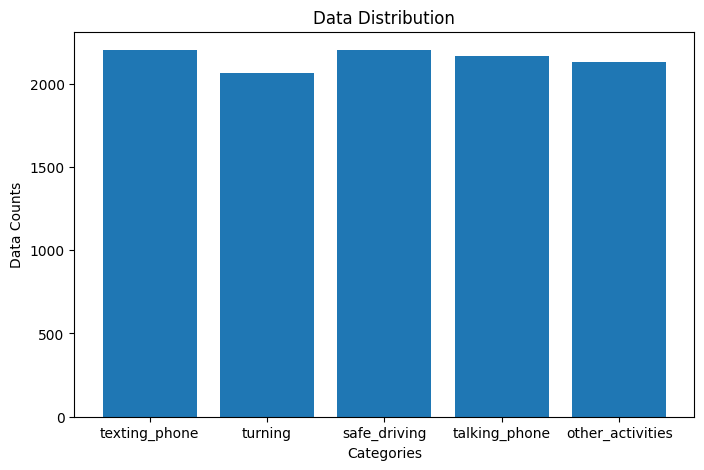

There're 10766 pictures in 5 categories in the dataset.

2203 pictures in texting_phone category.
2063 pictures in turning category.
2203 pictures in safe_driving category.
2169 pictures in talking_phone category.
2128 pictures in other_activities category.


In [24]:
plotDataDistribution(original_data_path)

Read information of images, if the image is readable, store its path and resolution in the data frame.

If the image is not readable, store the file path in a list.

In [25]:
df_pic_info,error_file = readImgInfo(original_data_path)

  0%|          | 0/10766 [00:00<?, ?it/s]

Take a look at the readable file data set:

In [26]:
df_pic_info.sample(10)

,height,width,path
10569,480,640,/content/data/other_activities/img_13520.jpg
4883,480,640,/content/data/safe_driving/img_3326.jpg
7789,480,640,/content/data/talking_phone/img_5565.jpg
10250,480,640,/content/data/other_activities/img_26585.jpg
2537,480,640,/content/data/turning/img_28127.jpg
10241,480,640,/content/data/other_activities/img_1723.jpg
4366,480,640,/content/data/safe_driving/img_28760.jpg
1381,480,640,/content/data/texting_phone/img_47439.jpg
10209,480,640,/content/data/other_activities/img_5969.jpg
4868,480,640,/content/data/safe_driving/img_60098.jpg


Show the files that could not be opened:

In [27]:
error_file

['/content/data/turning/img_8771.jpg',
 '/content/data/turning/img_67523.jpg',
 '/content/data/turning/img_70552.jpg',
 '/content/data/turning/img_101434.jpg',
 '/content/data/turning/img_62337.jpg',
 '/content/data/turning/img_84605.jpg',
 '/content/data/other_activities/img_4664.jpg',
 '/content/data/other_activities/img_7973.jpg',
 '/content/data/other_activities/img_79.jpg',
 '/content/data/other_activities/img_13625.jpg',
 '/content/data/other_activities/img_13541.jpg',
 '/content/data/other_activities/img_20398.jpg',
 '/content/data/other_activities/img_22266.jpg',
 '/content/data/other_activities/img_13396.jpg',
 '/content/data/other_activities/img_13318.jpg']

Look at the resolution of the pictures:

In [28]:
unique_height = df_pic_info['height'].unique()
unique_width = df_pic_info['width'].unique()

print(f"There\'re {len(unique_height)} different height(s): {','.join([str(i) for i in unique_height])}")
print(f"There\'re {len(unique_width)} different width(s): {','.join([str(i) for i in unique_width])}")

There're 2 different height(s): 480,384
There're 2 different width(s): 640,683


Resize the images to a uniform resolution, stored the resized images in another folder, store the resized path to a text file:

In [29]:
resized_data_path = resizePic(df_pic_info['path'],"data_cleaned",640,384)

  0%|          | 0/10751 [00:00<?, ?it/s]

Picture Resize:
Success:	 10751 
Failed:	 0


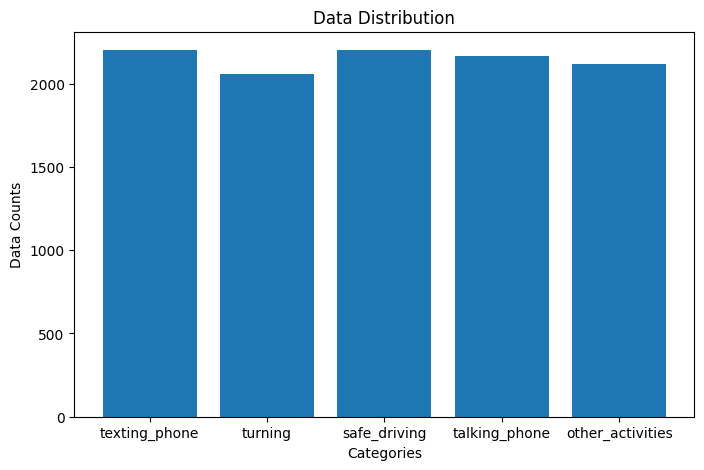

There're 10751 pictures in 5 categories in the dataset.

2203 pictures in texting_phone category.
2057 pictures in turning category.
2203 pictures in safe_driving category.
2169 pictures in talking_phone category.
2119 pictures in other_activities category.


In [30]:
plotDataDistribution(resized_data_path)

In [31]:
df_pic_info_resized ,error_file = readImgInfo(resized_data_path)

  0%|          | 0/10751 [00:00<?, ?it/s]

In [32]:
unique_height = df_pic_info_resized['height'].unique()
unique_width = df_pic_info_resized['width'].unique()

print(f"There\'re {len(unique_height)} different height(s): {','.join([str(i) for i in unique_height])}")
print(f"There\'re {len(unique_width)} different width(s): {','.join([str(i) for i in unique_width])}")

There're 1 different height(s): 384
There're 1 different width(s): 640


---

Read resized file path:

In [33]:
resized_data_path = readPathFromFile("data_cleaned")
resized_data_path

'/content/data_cleaned'

Generate `Train` and `Test` data set from resized data set, store new sets in another path:

In [34]:
train_path, test_path = generate_Train_Test(resized_data_path,'data_organized',0.8)

Total Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Train - texting_phone:   0%|          | 0/1762 [00:00<?, ?it/s]

Test - texting_phone:   0%|          | 0/441 [00:00<?, ?it/s]

Train - turning:   0%|          | 0/1646 [00:00<?, ?it/s]

Test - turning:   0%|          | 0/411 [00:00<?, ?it/s]

Train - safe_driving:   0%|          | 0/1762 [00:00<?, ?it/s]

Test - safe_driving:   0%|          | 0/441 [00:00<?, ?it/s]

Train - talking_phone:   0%|          | 0/1735 [00:00<?, ?it/s]

Test - talking_phone:   0%|          | 0/434 [00:00<?, ?it/s]

Train - other_activities:   0%|          | 0/1695 [00:00<?, ?it/s]

Test - other_activities:   0%|          | 0/424 [00:00<?, ?it/s]

Look at the data distribution in train set:

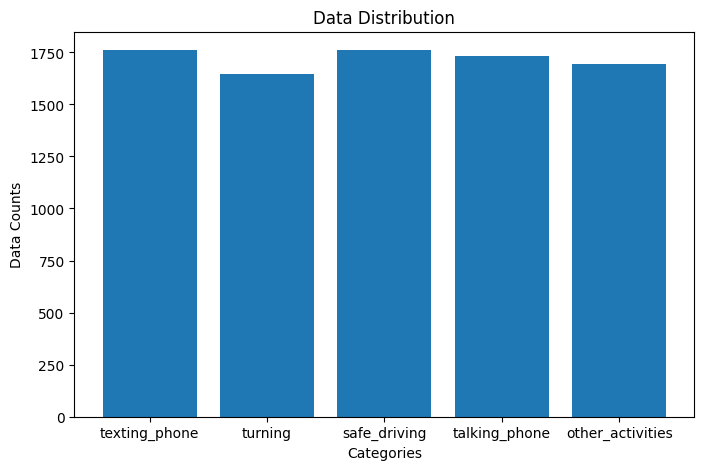

There're 8600 pictures in 5 categories in the dataset.

1762 pictures in texting_phone category.
1646 pictures in turning category.
1762 pictures in safe_driving category.
1735 pictures in talking_phone category.
1695 pictures in other_activities category.


In [35]:
plotDataDistribution(train_path)

We can see we have a balanced data across the categories.

Look at the data distribution in test set:

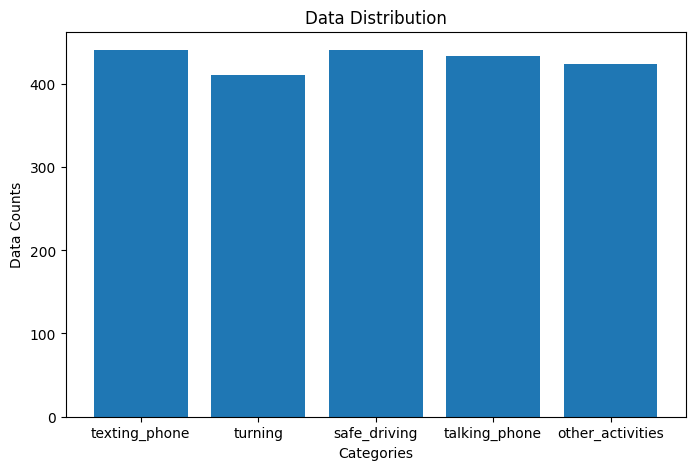

There're 2151 pictures in 5 categories in the dataset.

441 pictures in texting_phone category.
411 pictures in turning category.
441 pictures in safe_driving category.
434 pictures in talking_phone category.
424 pictures in other_activities category.


In [36]:
plotDataDistribution(test_path)

Read train & test data set path from text file:

In [37]:
train_path = readPathFromFile('train')
test_path = readPathFromFile('test')

In [38]:
train_path

'/content/data_organized/train'

Set Model Parameters:

In [39]:
# The number of categories we have
categories = os.listdir(train_path)

# The number of classes we are trying to classify
classes = len(categories)

# We will re-size the images to 64 by 64 pixels to cut down on computation time
#pixels = 64
pixels = 64

# They are colour images so they have 3 channels
channels = 3

# We want to work with 12 images at a time (in each batch)
batch_size = 12

input_shape = (pixels,pixels,channels)

print(f'We have {classes} categories we are trying to classify.')

We have 5 categories we are trying to classify.


In [40]:
# Instantiating the train generator
train_datagen = ImageDataGenerator(rescale=1./255,validation_split = 0.3)

# Instantiating the test generator
test_datagen = ImageDataGenerator(rescale=1./255)

In [41]:
train_generator,validation_generator, test_generator = imgGeneator()

train_stepsize = train_generator.samples // train_generator.batch_size
valid_stepsize = validation_generator.samples // validation_generator.batch_size
test_stepsize = test_generator.samples // test_generator.batch_size

print(f'\r\nTraining Sample Size:\t{train_generator.samples}\tBatch Size: {train_generator.batch_size}\tStep Size: {train_stepsize}\r\n')
print(f'Validation Sample Size:\t{validation_generator.samples}\tBatch Size: {validation_generator.batch_size}\tStep Size: {valid_stepsize}\r\n')
print(f'Test Sample Size:\t{test_generator.samples}\tBatch Size: {test_generator.batch_size}\tStep Size: {test_stepsize}\r\n')

Found 6023 images belonging to 5 classes.
Found 2577 images belonging to 5 classes.
Found 2151 images belonging to 5 classes.

Training Sample Size:	6023	Batch Size: 12	Step Size: 501

Validation Sample Size:	2577	Batch Size: 12	Step Size: 214

Test Sample Size:	2151	Batch Size: 12	Step Size: 179



Show how the pictures look in train and test folder:

**Train Set:**

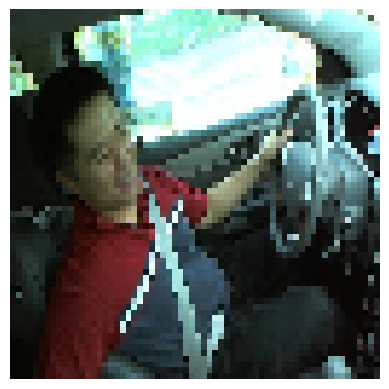

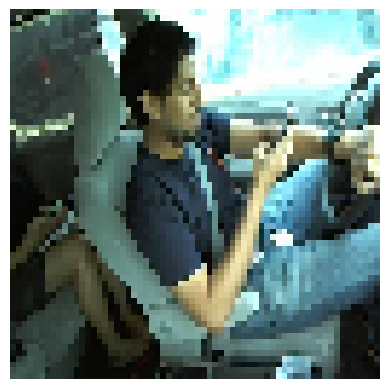

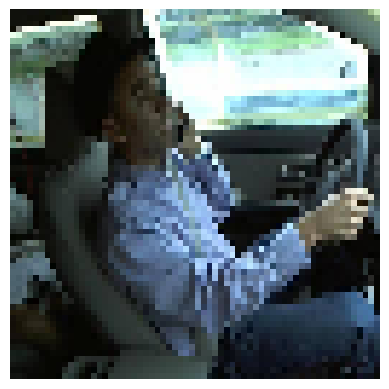

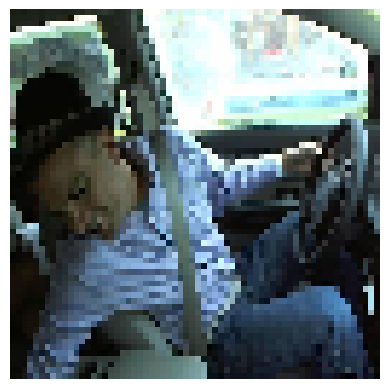

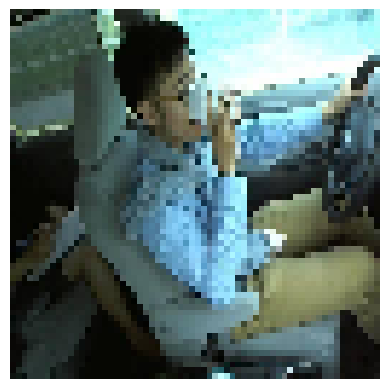

In [42]:
showGeneratorImage(train_generator,5)

**Test Set:**

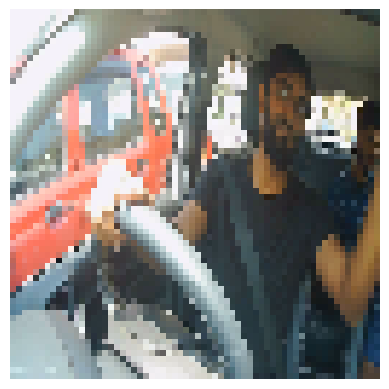

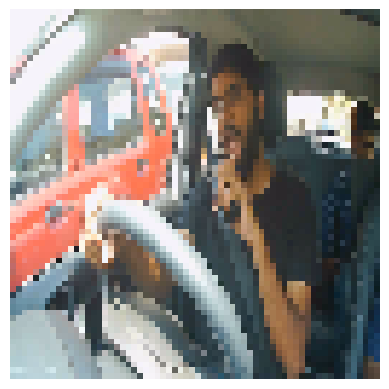

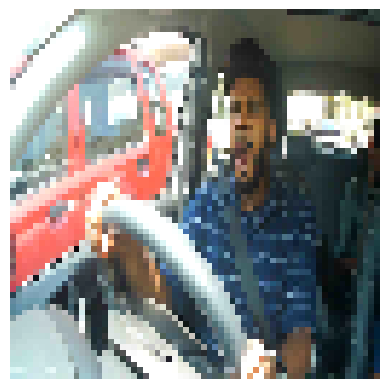

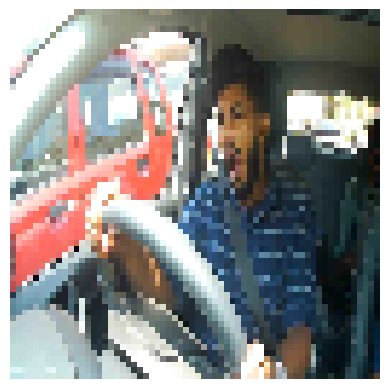

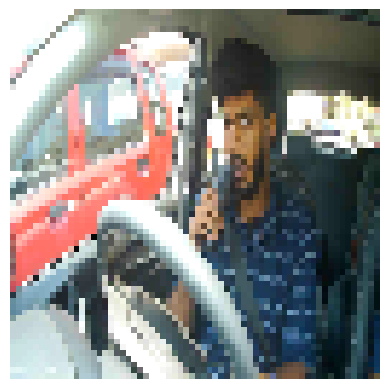

In [43]:
showGeneratorImage(test_generator,5)

Initialize Model:

---

**Transfer Learning From *MobileNet***

Using pre-trained MobileNet weights and one 5 neurons classifier output as the benchmark for the MobileNet transfer learning Model:

1. Initialize the model:

In [47]:
# Initialize pre-trained model
MobileNet_Benchmark = initPreTrained(input_shape,'mobilenet')

2. Compile the model:  

- default optimizer: Adam

- default learning rate: 0.0001

- loss function: categorical_crossentropy

- metrics: accuracy

In [48]:
# Compile the model
MobileNet_Benchmark = modelCompile(MobileNet_Benchmark)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 1024)           │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,233,989 (12.34 MB)

 Trainable params: 5,125 (20.02 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

None


3. Train and evaluate the benchmark model:

Epoch 1/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.2047 - loss: 2.3442 - val_accuracy: 0.3384 - val_loss: 1.7216
Epoch 2/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5833 - loss: 1.4595 - val_accuracy: 0.3392 - val_loss: 1.7216
Epoch 3/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.3930 - loss: 1.5291 - val_accuracy: 0.4618 - val_loss: 1.4137
Epoch 4/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5000 - loss: 1.0921 - val_accuracy: 0.4618 - val_loss: 1.4180
Epoch 5/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5112 - loss: 1.2127 - val_accuracy: 0.5280 - val_loss: 1.2308
Epoch 6/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7500 - loss: 1.0913 - val_accuracy: 0.5284 - val_loss: 1.2296
Epoch 7/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - accuracy: 0.5896 - loss: 1.0436 - val_accuracy: 0.5829 - val_loss: 1.1167
Epoch 8/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5833 - loss: 0.9270 - val_

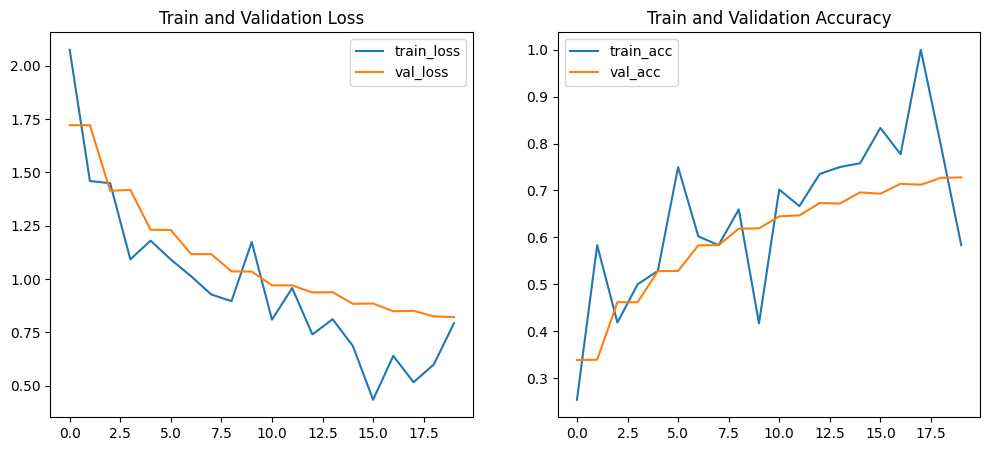

180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step
Classification Report

                   precision    recall  f1-score   support

   texting_phone       0.64      0.61      0.62       424
         turning       0.76      0.83      0.79       441
    safe_driving       0.73      0.68      0.70       434
   talking_phone       0.74      0.76      0.75       441
other_activities       0.92      0.92      0.92       411

        accuracy                           0.76      2151
       macro avg       0.76      0.76      0.76      2151
    weighted avg       0.76      0.76      0.76      2151



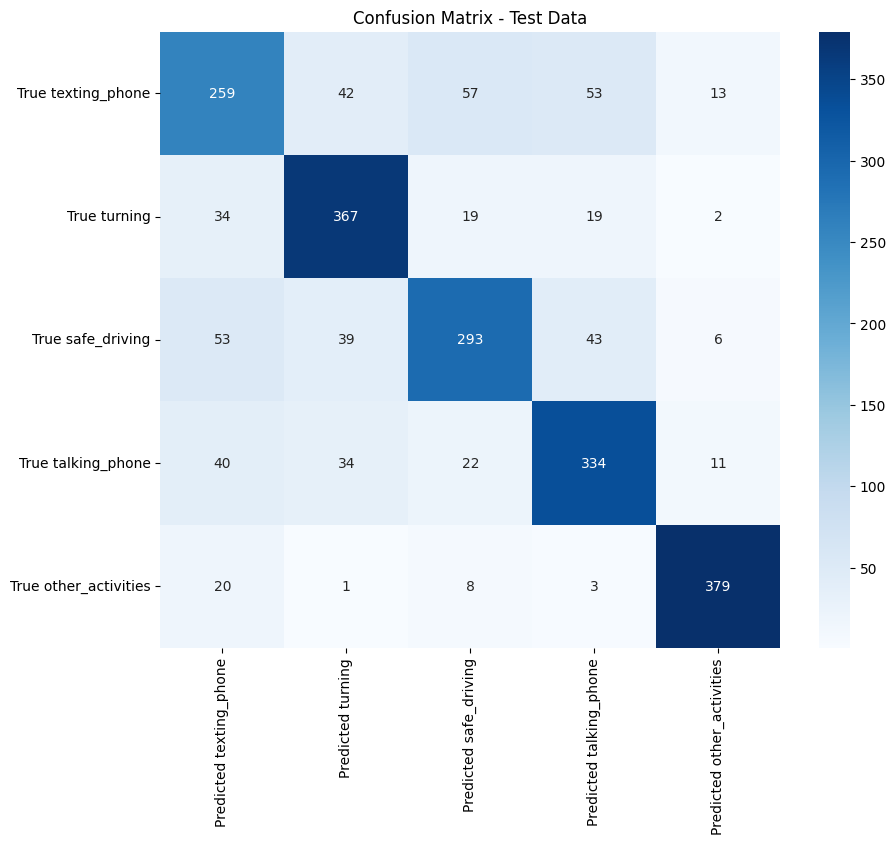

In [49]:
# returns (model, history,test_probas,test_predictions)
MobileNet_Benchmark =  model_Fit_Evaluate(MobileNet_Benchmark,20)

4. Save the benchmark model:

In [50]:
MobileNet_Benchmark[0].save('MobileNet_Benchmark.h5')


**Tweak MobileNet Benchmark Model:**

Add 3 hidden layers to the benchmark model, dropout is 0.15

1. Load the benchmark model:

In [51]:
# Read Becnmark model
MobileNet_Benchmark = tf.keras.models.load_model('MobileNet_Benchmark.h5')


2. Add layers and compile the model:

In [52]:
# Define layers, integer indicates neuron number, decimal indicates dropout rate
new_layers = [243, 0.15, 243, 0.15, 81]


MobileNet_3Layers = addLayers2Model_compile(MobileNet_Benchmark,new_layers)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 1024)           │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 243)            │       249,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 243)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 243)            │        59,292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 243)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 81)             │        19,764 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,557,405 (13.57 MB)

 Trainable params: 328,541 (1.25 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

None


3. Train and evaluate the model:

Epoch 1/25
501/501 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.3270 - loss: 1.6283 - val_accuracy: 0.6262 - val_loss: 1.0031
Epoch 2/25
501/501 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5000 - loss: 1.1290 - val_accuracy: 0.6227 - val_loss: 1.0030
Epoch 3/25
501/501 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.6386 - loss: 0.9145 - val_accuracy: 0.7422 - val_loss: 0.7745
Epoch 4/25
501/501 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7500 - loss: 0.7295 - val_accuracy: 0.7403 - val_loss: 0.7796
Epoch 5/25
501/501 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.7552 - loss: 0.6475 - val_accuracy: 0.7987 - val_loss: 0.6482
Epoch 6/25
501/501 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8333 - loss: 0.5004 - val_accuracy: 0.7983 - val_loss: 0.6458
Epoch 7/25
501/501 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.8354 - loss: 0.4513 - val_accuracy: 0.8298 - val_loss: 0.5824
Epoch 8/25
501/501 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9167 - loss: 0.4835 - val_

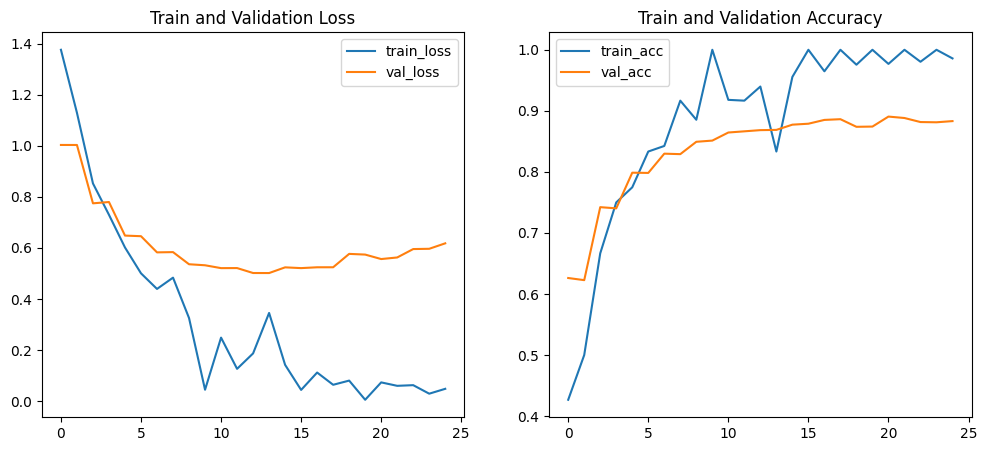

180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step
Classification Report

                   precision    recall  f1-score   support

   texting_phone       0.91      0.86      0.88       424
         turning       0.96      0.91      0.94       441
    safe_driving       0.93      0.89      0.91       434
   talking_phone       0.84      0.96      0.90       441
other_activities       0.96      0.97      0.96       411

        accuracy                           0.92      2151
       macro avg       0.92      0.92      0.92      2151
    weighted avg       0.92      0.92      0.92      2151



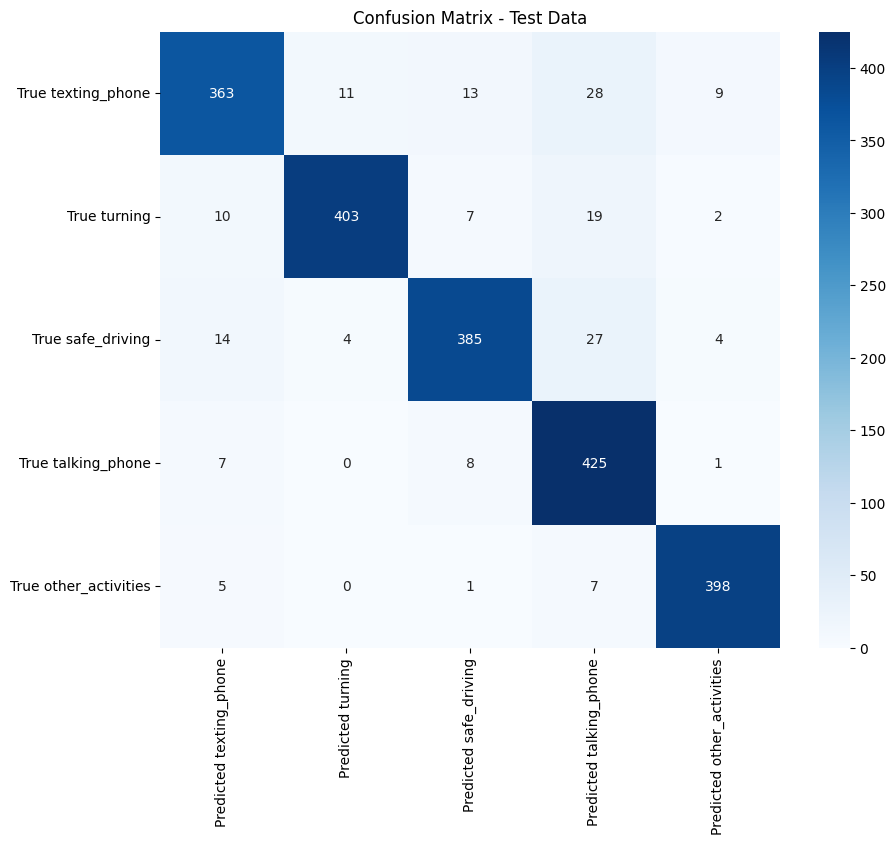

In [53]:
MobileNet_3Layers =  model_Fit_Evaluate(MobileNet_3Layers,25)

4. Save the model:

In [54]:
MobileNet_3Layers[0].save('MobileNet_3Layers.h5')


**Tweak MobileNet Benchmark Model:**

Add 5 hidden layers to the benchmark model with different dropout.

1. Load the benchmark model:

In [55]:
MobileNet_Benchmark = tf.keras.models.load_model('MobileNet_Benchmark.h5')


2. Add layers and compile the Model:
- Add 5 hidden layers to the benchmark model with different dropout.

In [56]:
# Define layers, integer indicates neuron number, decimal indicates dropout rate
new_layers = [512,0.2, 371,0.1, 243, 0.15, 243, 0.15, 81]


MobileNet_5Layers = addLayers2Model_compile(MobileNet_Benchmark,new_layers)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 1024)           │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 371)            │       190,323 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 371)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 243)            │        90,396 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 243)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 243)            │        59,292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 243)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 81)             │        19,764 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,113,849 (15.69 MB)

 Trainable params: 884,985 (3.38 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

None


3. Train and evaluate the model:

Epoch 1/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.3165 - loss: 1.5288 - val_accuracy: 0.6406 - val_loss: 0.9694
Epoch 2/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5000 - loss: 1.1759 - val_accuracy: 0.6417 - val_loss: 0.9658
Epoch 3/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.6212 - loss: 0.9365 - val_accuracy: 0.7625 - val_loss: 0.6959
Epoch 4/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8333 - loss: 0.4018 - val_accuracy: 0.7656 - val_loss: 0.6948
Epoch 5/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.7801 - loss: 0.5889 - val_accuracy: 0.8189 - val_loss: 0.5902
Epoch 6/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7500 - loss: 0.8063 - val_accuracy: 0.8178 - val_loss: 0.5900
Epoch 7/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - accuracy: 0.8640 - loss: 0.3735 - val_accuracy: 0.8559 - val_loss: 0.5038
Epoch 8/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 1.0000 - loss: 0.1260 - val_a

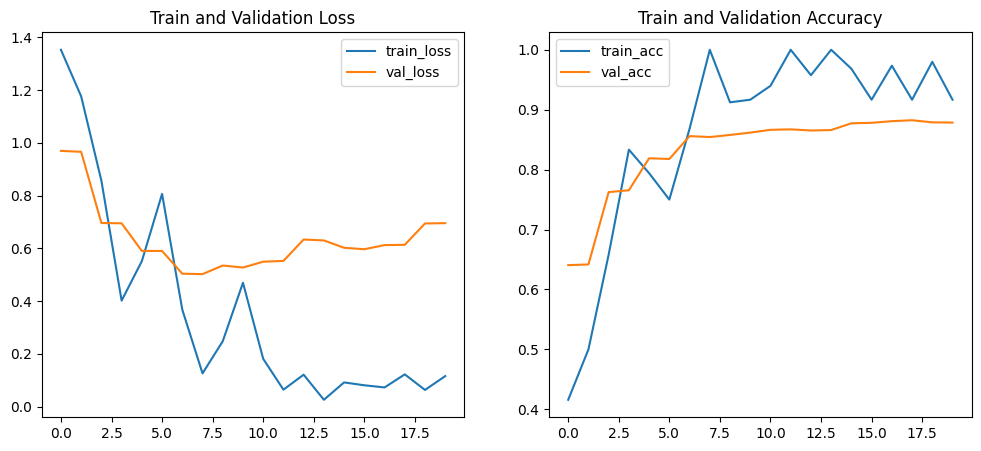

180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step
Classification Report

                   precision    recall  f1-score   support

   texting_phone       0.86      0.91      0.88       424
         turning       0.98      0.88      0.92       441
    safe_driving       0.93      0.88      0.90       434
   talking_phone       0.90      0.95      0.93       441
other_activities       0.93      0.98      0.95       411

        accuracy                           0.92      2151
       macro avg       0.92      0.92      0.92      2151
    weighted avg       0.92      0.92      0.92      2151



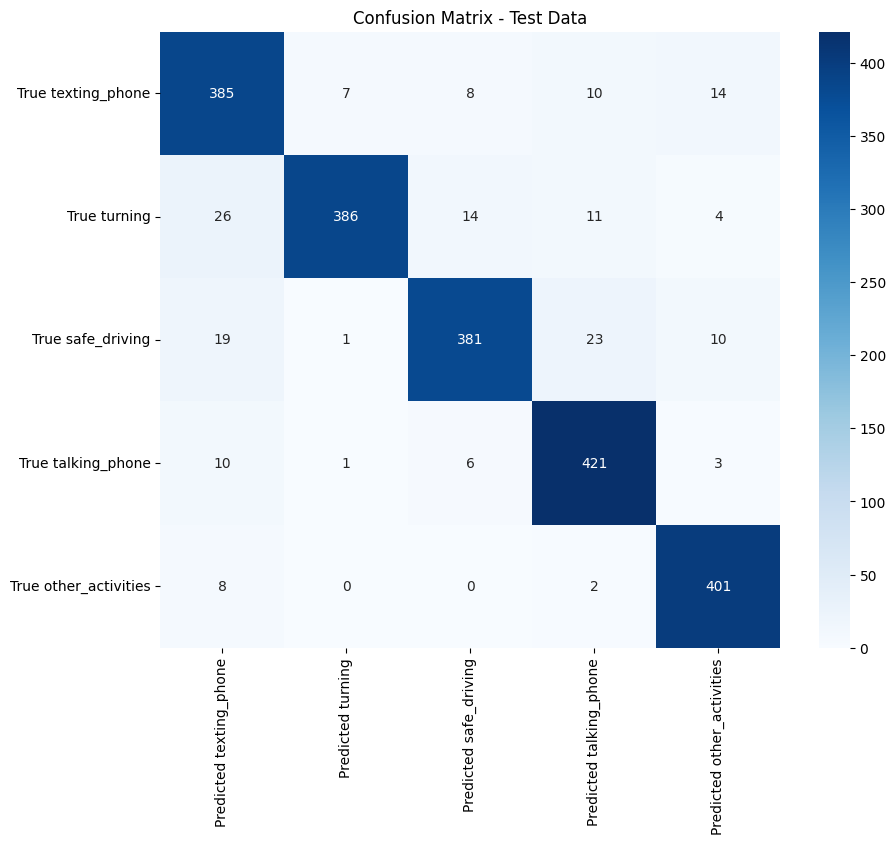

In [57]:
MobileNet_5Layers =  model_Fit_Evaluate(MobileNet_5Layers,20)

4. Save the model:

In [58]:
MobileNet_5Layers[0].save('MobileNet_5Layers.h5')


As we can see from above classification report and accuracy, both `VGG16_Benchmark` & `VGG19_Benchmark` have the lowest perfomance, they  took much longer time to make the prediction by given the same size of data points. If our model is going to be use in an embedded system, we need a model which will not consume too much time on reaction.

Let's take a look at the model performance after added 3 more hidden layers.

**MobileNet with 3 more hidden layers**

In [59]:
printClassificationReport(MobileNet_3Layers[0])

180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
Prediction Time: 3 seconds.

Classification Report

                   precision    recall  f1-score   support

   texting_phone       0.91      0.86      0.88       424
         turning       0.96      0.91      0.94       441
    safe_driving       0.93      0.89      0.91       434
   talking_phone       0.84      0.96      0.90       441
other_activities       0.96      0.97      0.96       411

        accuracy                           0.92      2151
       macro avg       0.92      0.92      0.92      2151
    weighted avg       0.92      0.92      0.92      2151



Accuracy:

In [60]:
MobileNet_3Layers[0].evaluate(
    test_generator,
    steps=test_stepsize,
    verbose=1
)


179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8749 - loss: 0.5197


[0.32493072748184204, 0.917597770690918]

From the f1-score of the classification report and accuracy, it tells us MobileNet and MobileNetV2 are pretty good, MobileNet(91% accurate) is slightly better than MobileNetV2(89% accurate).

Let's see how it goes with 5 hidden layers:

**MobileNet with 5 hidden layers:**

In [61]:
printClassificationReport(MobileNet_5Layers[0])

180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
Prediction Time: 3 seconds.

Classification Report

                   precision    recall  f1-score   support

   texting_phone       0.86      0.91      0.88       424
         turning       0.98      0.88      0.92       441
    safe_driving       0.93      0.88      0.90       434
   talking_phone       0.90      0.95      0.93       441
other_activities       0.93      0.98      0.95       411

        accuracy                           0.92      2151
       macro avg       0.92      0.92      0.92      2151
    weighted avg       0.92      0.92      0.92      2151



Accuracy:

In [62]:
MobileNet_5Layers[0].evaluate(
    test_generator, steps=test_stepsize, verbose=1
)


179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8926 - loss: 0.5256


[0.3606939911842346, 0.917597770690918]

180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step


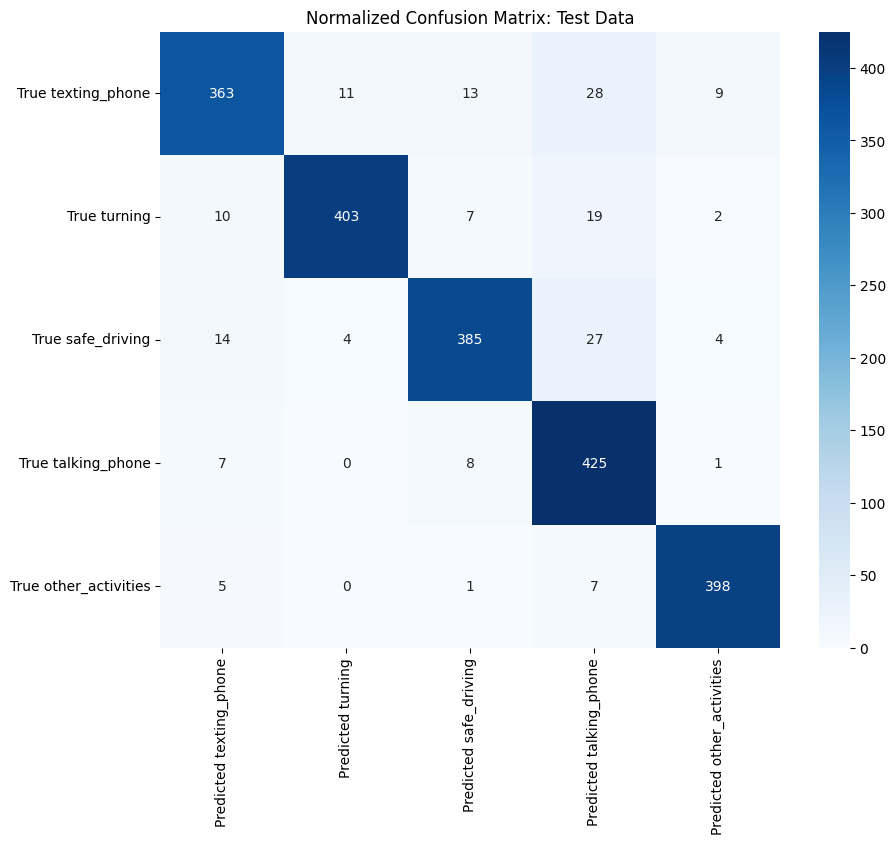

In [63]:
plotConfusionMatrix(MobileNet_3Layers[0])

Saving img_1441.jpg to img_1441.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
This image most likely belongs to 'talking_phone' with a 99.91999816894531% probability.


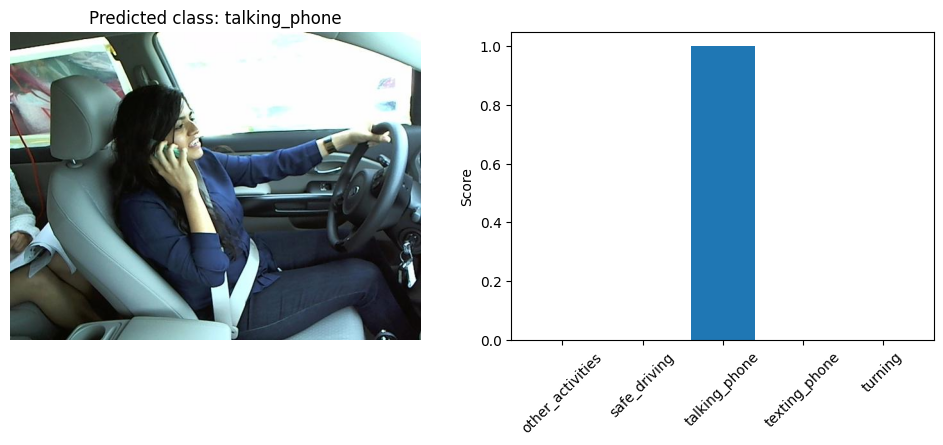

In [64]:
predicOnPicture(MobileNet_3Layers[0])